# COVID19 logistic regression

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
data = pd.read_csv('COVID-19_Case_Data_Clean.csv')
data.head()

,cdc_report_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,interval_dt
0,2020/8/17,2020/8/9,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,8.0
1,2020/4/10,2020/3/26,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,15.0
2,2020/7/27,2020/7/13,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,14.0
3,2020/8/10,2020/8/5,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,5.0
4,2020/8/17,2020/8/6,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,11.0


In [5]:
data.apply(lambda col: len(col.unique()))

cdc_report_dt                    261
onset_dt                         300
current_status                     2
sex                                2
age_group                         10
Race and ethnicity (combined)      8
hosp_yn                            2
icu_yn                             2
death_yn                           2
medcond_yn                         2
interval_dt                      361
dtype: int64

In [6]:
col = ['current_status','sex','age_group','Race and ethnicity (combined)','hosp_yn','icu_yn','death_yn','medcond_yn']
df = pd.get_dummies(data, columns = col, drop_first=True)
df.head()
df.shape

,cdc_report_dt,onset_dt,interval_dt,current_status_Probable Case,sex_Male,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,...,"Race and ethnicity (combined)_Black, Non-Hispanic",Race and ethnicity (combined)_Hispanic/Latino,"Race and ethnicity (combined)_Multiple/Other, Non-Hispanic","Race and ethnicity (combined)_Native Hawaiian/Other Pacific Islander, Non-Hispanic",Race and ethnicity (combined)_Unknown,"Race and ethnicity (combined)_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
0,2020/8/17,2020/8/9,8.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2020/4/10,2020/3/26,15.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2020/7/27,2020/7/13,14.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2020/8/10,2020/8/5,5.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2020/8/17,2020/8/6,11.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


(411862, 24)

In [7]:
df=df.dropna(subset=['interval_dt'],axis=0)
df.shape

(369690, 24)

In [33]:
df.columns

Index(['cdc_report_dt', 'onset_dt', 'interval_dt',
       'current_status_Probable Case', 'sex_Male', 'age_group_10 - 19 Years',
       'age_group_20 - 29 Years', 'age_group_30 - 39 Years',
       'age_group_40 - 49 Years', 'age_group_50 - 59 Years',
       'age_group_60 - 69 Years', 'age_group_70 - 79 Years',
       'age_group_80+ Years',
       'Race and ethnicity (combined)_Asian, Non-Hispanic',
       'Race and ethnicity (combined)_Black, Non-Hispanic',
       'Race and ethnicity (combined)_Hispanic/Latino',
       'Race and ethnicity (combined)_Multiple/Other, Non-Hispanic',
       'Race and ethnicity (combined)_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'Race and ethnicity (combined)_Unknown',
       'Race and ethnicity (combined)_White, Non-Hispanic', 'hosp_yn_Yes',
       'icu_yn_Yes', 'death_yn_Yes', 'medcond_yn_Yes'],
      dtype='object')

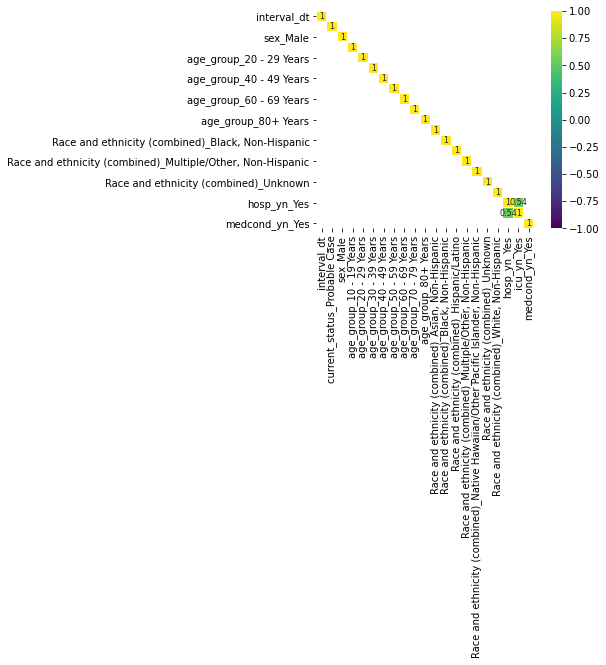

In [82]:
corr = df.drop('death_yn_Yes', axis =1).corr()
sns.heatmap(corr[(corr >= 0.5) |(corr <= -0.5)],
           cmap= 'viridis', vmax = 1.0, vmin = -1.0, linewidths = 0.1,
           annot = True, annot_kws={"size":8}, square =True);

In [9]:
y = df['death_yn_Yes']
x = df.drop(['death_yn_Yes','cdc_report_dt','onset_dt'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [10]:
pipe = Pipeline([('pca', PCA()),('lg', LogisticRegression(C=0.01, solver = 'lbfgs', max_iter = 1000))])
param_grid = {'pca__n_components':  range(5, 20),'lg__C':[1000,100,10,1,0.1,0.01]}
grid = GridSearchCV(pipe, cv = 5, param_grid = param_grid, scoring = 'roc_auc', refit=True, verbose=1)
grid_fit = grid.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 40.5min finished


In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.962 (std: 0.001)
Parameters: {'lg__C': 0.1, 'pca__n_components': 17}

Model with rank: 2
Mean validation score: 0.962 (std: 0.001)
Parameters: {'lg__C': 0.1, 'pca__n_components': 18}

Model with rank: 3
Mean validation score: 0.962 (std: 0.001)
Parameters: {'lg__C': 0.1, 'pca__n_components': 19}



In [12]:
predict_prob = grid.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1])

print('AUC: {:.2f}'.format(auc(fpr, tpr)))

AUC: 0.96


<Figure size 504x360 with 0 Axes>

Text(0.5, 1.0, 'AUC of Logistic Model')

Text(0.5, 0, 'False Positive Rate (1-Specificity)')

Text(0, 0.5, 'True Positive Rate (Recall)')

(0.0, 1.0)

(0.0, 1.0)

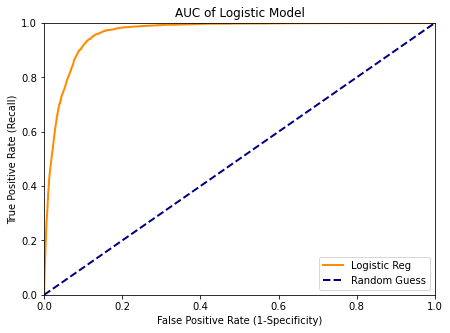

In [84]:
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Logistic Reg')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
plt.title('AUC of Logistic Model')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Recall)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

plt.savefig('AUC.png')

In [14]:
predict = grid.predict(x_test)
cm = confusion_matrix(y_test, predict)
print('confusion matrix:\n', cm)

print('classification report:\n', classification_report(y_test, predict))

confusion matrix:
 [[68162  1113]
 [ 2467  2196]]
classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     69275
           1       0.66      0.47      0.55      4663

    accuracy                           0.95     73938
   macro avg       0.81      0.73      0.76     73938
weighted avg       0.95      0.95      0.95     73938



In [28]:
lg = LogisticRegression(C=0.1, solver = 'lbfgs', max_iter = 1000)
lg.fit(x_train, y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [62]:
x_train.columns

Index(['interval_dt', 'current_status_Probable Case', 'sex_Male',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years',
       'Race and ethnicity (combined)_Asian, Non-Hispanic',
       'Race and ethnicity (combined)_Black, Non-Hispanic',
       'Race and ethnicity (combined)_Hispanic/Latino',
       'Race and ethnicity (combined)_Multiple/Other, Non-Hispanic',
       'Race and ethnicity (combined)_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'Race and ethnicity (combined)_Unknown',
       'Race and ethnicity (combined)_White, Non-Hispanic', 'hosp_yn_Yes',
       'icu_yn_Yes', 'medcond_yn_Yes'],
      dtype='object')

In [69]:
lg.coef_

array([[ 1.28256319e-02, -4.36428507e-01,  3.00363309e-01,
        -1.39830121e+00, -1.10784889e+00, -5.62200534e-01,
        -9.56421561e-05,  5.59910396e-01,  1.19607620e+00,
         1.92937583e+00,  3.34557577e+00,  1.30381325e-01,
         4.62867313e-02,  1.01137844e-01, -3.21473212e-02,
        -3.56092362e-01, -2.56451540e-01, -2.05145298e-01,
         1.63125847e+00,  2.04866521e+00,  1.20027610e+00]])

### sex

In [77]:
lg.coef_[:,2]

array([0.30036331])

In [87]:
np.exp(0.30036331)

1.3503493138769103

### ethnic

In [75]:
lg.coef_[:,11:18]

array([[ 0.13038133,  0.04628673,  0.10113784, -0.03214732, -0.35609236,
        -0.25645154, -0.2051453 ]])

In [88]:
np.exp(lg.coef_[:,11:18])

array([[1.13926273, 1.04737468, 1.10642915, 0.96836391, 0.70040793,
        0.77379249, 0.81452896]])

### age group

In [92]:
lg.coef_[:,3:11]

array([[-1.39830121e+00, -1.10784889e+00, -5.62200534e-01,
        -9.56421561e-05,  5.59910396e-01,  1.19607620e+00,
         1.92937583e+00,  3.34557577e+00]])

In [93]:
np.exp(lg.coef_[:,3:11])

array([[ 0.24701624,  0.33026864,  0.56995348,  0.99990436,  1.75051564,
         3.30711498,  6.88521138, 28.37690944]])

### Probable Case

In [78]:
lg.coef_[:,1]

array([-0.43642851])

In [89]:
np.exp(lg.coef_[:,1])

array([0.6463407])

### interval_dt

In [79]:
lg.coef_[:,0]

array([0.01282563])

### Hosp, ICU, medcon

In [80]:
lg.coef_[:,18:21]

array([[1.63125847, 2.04866521, 1.2002761 ]])

In [90]:
np.exp(lg.coef_[:,18:21])

array([[5.11030183, 7.75753952, 3.32103372]])

### intercept

In [30]:
lg.intercept_

array([-6.29735742])

In [32]:
np.max(lg.coef_)

3.3455757665951906

In [40]:
np.min(lg.coef_)

-1.3983012066614569

In [38]:
predict_prob_lg = lg.predict_proba(x_test)

fpr2, tpr2, thresholds2 = roc_curve(y_test, predict_prob_lg[:, 1])

print('AUC: {:.2f}'.format(auc(fpr2, tpr2)))

AUC: 0.96


In [39]:
predict2 = lg.predict(x_test)
cm2 = confusion_matrix(y_test, predict2)
print('confusion matrix:\n', cm2)

print('classification report:\n', classification_report(y_test, predict2))

confusion matrix:
 [[68155  1120]
 [ 2465  2198]]
classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     69275
           1       0.66      0.47      0.55      4663

    accuracy                           0.95     73938
   macro avg       0.81      0.73      0.76     73938
weighted avg       0.95      0.95      0.95     73938



In [42]:
x2 = df.drop(['death_yn_Yes','cdc_report_dt', 'onset_dt', 'interval_dt',
       'current_status_Probable Case', 'sex_Male', 'age_group_10 - 19 Years',
       'age_group_20 - 29 Years', 'age_group_30 - 39 Years',
       'age_group_40 - 49 Years', 'age_group_50 - 59 Years',
       'age_group_60 - 69 Years', 'age_group_70 - 79 Years',
       'age_group_80+ Years',
       'Race and ethnicity (combined)_Asian, Non-Hispanic',
       'Race and ethnicity (combined)_Black, Non-Hispanic',
       'Race and ethnicity (combined)_Hispanic/Latino',
       'Race and ethnicity (combined)_Multiple/Other, Non-Hispanic',
       'Race and ethnicity (combined)_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'Race and ethnicity (combined)_Unknown',
       'Race and ethnicity (combined)_White, Non-Hispanic',], axis = 1)
x2.head()

,hosp_yn_Yes,icu_yn_Yes,medcond_yn_Yes
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [44]:
x2_train, x2_test, y_train, y_test = train_test_split(x2, y, test_size = 0.2, random_state = 42)

In [47]:
lg2=LogisticRegression(C=0.1, solver = 'lbfgs', max_iter = 1000)

In [52]:
pipe = Pipeline([('pca', PCA()),('lg', LogisticRegression(C=0.01, solver = 'lbfgs', max_iter = 1000))])
param_grid = {'pca__n_components':  range(0, 4),'lg__C':[1000,100,10,1,0.1,0.01]}
grid2 = GridSearchCV(pipe, cv = 5, param_grid = param_grid, scoring = 'roc_auc', refit=True, verbose=1)
grid2.fit(x2_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   46.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lg',
                                        LogisticRegression(C=0.01,
                                                           max_iter=1000))]),
             param_grid={'lg__C': [1000, 100, 10, 1, 0.1, 0.01],
                         'pca__n_components': range(0, 4)},
             scoring='roc_auc', verbose=1)

In [53]:
report(grid2.cv_results_)

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 1000, 'pca__n_components': 2}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 1000, 'pca__n_components': 3}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 100, 'pca__n_components': 2}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 100, 'pca__n_components': 3}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 10, 'pca__n_components': 2}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 10, 'pca__n_components': 3}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 1, 'pca__n_components': 2}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 1, 'pca__n_components': 3}

Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'lg__C': 0.1, 'pca__n_comp

In [54]:
predict_prob2 = grid2.predict_proba(x2_test)

fpr3, tpr3, thresholds3 = roc_curve(y_test, predict_prob2[:, 1])

print('AUC: {:.2f}'.format(auc(fpr3, tpr3)))

AUC: 0.92


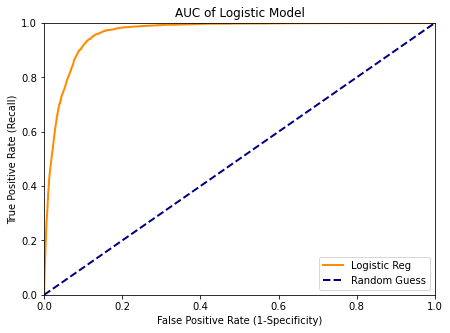

In [55]:
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Logistic Reg')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
plt.title('AUC of Logistic Model')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Recall)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show();

In [56]:
predict3 = grid2.predict(x2_test)
cm3 = confusion_matrix(y_test, predict3)
print('confusion matrix:\n', cm3)

print('classification report:\n', classification_report(y_test, predict3))

confusion matrix:
 [[67481  1794]
 [ 2308  2355]]
classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     69275
           1       0.57      0.51      0.53      4663

    accuracy                           0.94     73938
   macro avg       0.77      0.74      0.75     73938
weighted avg       0.94      0.94      0.94     73938



In [58]:
lg2 = LogisticRegression(C=1000, solver = 'lbfgs', max_iter = 1000)
lg2.fit(x2_train,y_train)

LogisticRegression(C=1000, max_iter=1000)

In [59]:
lg2.coef_

array([[2.55241924, 1.63858532, 1.96050898]])